# **Import libraries and modules**

In [1]:
import datasets
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertConfig, DataCollatorWithPadding, get_scheduler
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import torch.optim as optim
from tqdm.auto import tqdm
from evaluate import load
from collections import Counter

In [2]:
#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Task 1: Load and Prepare Dataset**

# Hate Speech and Offensive Language Dataset

## Dataset Information
This dataset is used for **text classification** tasks, specifically for detecting **hate speech** and **offensive language** in tweets. It contains **24.8k rows** of annotated tweets, categorized into three classes:
- **0: Hate Speech**
- **1: Offensive Language**
- **2: Neither**

### Dataset Details
- **Source**: [Hugging Face Dataset - tdavidson/hate_speech_offensive](https://huggingface.co/datasets/tdavidson/hate_speech_offensive)
- **Modalities**: Tabular, Text
- **Format**: Parquet
- **Language**: English
- **Size**: 10K - 100K rows
- **License**: MIT License

### Dataset Fields
- `count`: Number of users who coded each tweet.
- `hate_speech_count`: Number of users who judged the tweet as hate speech.
- `offensive_language_count`: Number of users who judged the tweet as offensive.
- `neither_count`: Number of users who judged the tweet as neither.
- `class`: Class label (0: hate speech, 1: offensive language, 2: neither).
- `tweet`: The text of the tweet.

### Example Data
```json
{
  "count": 3,
  "hate_speech_count": 0,
  "offensive_language_count": 0,
  "neither_count": 3,
  "class": 2,
  "tweet": "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. & as a man you should always take the trash out..."
}


@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar},
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
}

In [4]:
print("Task 1: Loading and Preparing Dataset")

# Load dataset
raw_datasets = datasets.load_dataset('hate_speech_offensive')

# Total available examples in 'train' split
full_data = raw_datasets['train']
total_size = len(full_data)  # ~24,783
print(f"Total dataset size: {total_size}")

# Reserve 2,000 for validation + test, use the rest for training
val_test_size = 2000
train_size =  total_size - val_test_size  # ~22,783

# Shuffle and split
full_data_shuffled = full_data.shuffle(seed=42)
train_data = full_data_shuffled.select(range(train_size))  # ~22,783 examples
val_test_data = full_data_shuffled.select(range(train_size, total_size))  # 2,000 examples


# Split val_test_data into validation and test
val_test_split = val_test_data.train_test_split(test_size=0.5, seed=42)
val_data = val_test_split['train']  # 1,000 examples
test_data = val_test_split['test']  # 1,000 examples

raw_datasets = datasets.DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})

# Tokenizer
teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

def tokenize_function(examples):
    result = tokenizer(examples['tweet'], max_length=128, truncation=True)
    result['labels'] = examples['class']
    return result

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])

# DataLoaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=32, collate_fn=data_collator)

print(f"Train size: {len(tokenized_datasets['train'])}")
print(f"Validation size: {len(tokenized_datasets['validation'])}")
print(f"Test size: {len(tokenized_datasets['test'])}")

Task 1: Loading and Preparing Dataset
Total dataset size: 24783
Train size: 22783
Validation size: 1000
Test size: 1000


# **Task 2: Odd Layer vs Even Layer Distillation**

In [5]:
print("\nTask 2: Odd Layer vs Even Layer Distillation")

# Define labels
id2label = {0: "hate_speech", 1: "offensive_language", 2: "neither"}
label2id = {v: k for k, v in id2label.items()}

# Load and fine-tune teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, num_labels=3, id2label=id2label, label2id=label2id
)
teacher_model.config.output_hidden_states = True
teacher_model.to(device)


Task 2: Odd Layer vs Even Layer Distillation


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### **Optimizer**

In [6]:
optimizer = optim.AdamW(teacher_model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [7]:
print("Fine-tuning Teacher Model")
progress_bar = tqdm(range(num_training_steps))
teacher_train_losses = []
for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = teacher_model(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    avg_loss = train_loss / len(train_dataloader)
    teacher_train_losses.append(avg_loss)
    print(f"Teacher Epoch {epoch+1}: Train Loss {avg_loss:.4f}")

Fine-tuning Teacher Model


  0%|          | 0/2136 [00:00<?, ?it/s]

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Teacher Epoch 1: Train Loss 0.3064
Teacher Epoch 2: Train Loss 0.2091
Teacher Epoch 3: Train Loss 0.1428


In [8]:
student_config = BertConfig(
    num_hidden_layers=6, num_attention_heads=12, hidden_size=768,
    intermediate_size=3072, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
    num_labels=3, output_hidden_states=True
)

def copy_layers(src_layers, dest_layers, layers_to_copy):
    layers_to_copy = nn.ModuleList([src_layers[i] for i in layers_to_copy])
    dest_layers.load_state_dict(layers_to_copy.state_dict())

loss_fct = nn.KLDivLoss(reduction="batchmean")
cosine_loss_fct = nn.CosineEmbeddingLoss(reduction="mean")

def train_student(student_model, teacher_model, train_dataloader, eval_dataloader, model_name="Student"):
    optimizer = optim.AdamW(student_model.parameters(), lr=5e-5)
    num_training_steps = len(train_dataloader) * num_epochs
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    progress_bar = tqdm(range(num_training_steps))
    student_model.to(device)
    teacher_model.eval()
    
    # Lists to store losses
    train_losses = []
    val_losses = []
    train_loss_cls = []
    train_loss_cos = []
    
    for epoch in range(num_epochs):
        student_model.train()
        total_train_loss = 0
        total_cls_loss = 0
        total_cos_loss = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                teacher_outputs = teacher_model(**batch)
            outputs = student_model(**batch)
            
            # Classification loss (KL Divergence)
            loss_ce = loss_fct(
                F.log_softmax(outputs.logits / 2.0, dim=-1),
                F.softmax(teacher_outputs.logits / 2.0, dim=-1),
            ) * (2.0 ** 2)
            
            # Cosine embedding loss
            student_cls_hidden = outputs.hidden_states[-1][:, 0, :]
            teacher_cls_hidden = teacher_outputs.hidden_states[-1][:, 0, :]
            loss_cos = cosine_loss_fct(
                student_cls_hidden,
                teacher_cls_hidden,
                torch.ones(student_cls_hidden.size(0)).to(device)
            )
            
            # Total loss
            loss = 0.5 * loss_ce + 0.5 * loss_cos
            total_train_loss += loss.item()
            total_cls_loss += loss_ce.item()
            total_cos_loss += loss_cos.item()
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        
        # Average training losses for the epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_cls_loss = total_cls_loss / len(train_dataloader)
        avg_cos_loss = total_cos_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_loss_cls.append(avg_cls_loss)
        train_loss_cos.append(avg_cos_loss)
        print(f"{model_name} Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, CLS Loss {avg_cls_loss:.4f}, COS Loss {avg_cos_loss:.4f}")
        
        # Compute validation loss
        student_model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                teacher_outputs = teacher_model(**batch)
                outputs = student_model(**batch)
                loss_ce = loss_fct(
                    F.log_softmax(outputs.logits / 2.0, dim=-1),
                    F.softmax(teacher_outputs.logits / 2.0, dim=-1),
                ) * (2.0 ** 2)
                student_cls_hidden = outputs.hidden_states[-1][:, 0, :]
                teacher_cls_hidden = teacher_outputs.hidden_states[-1][:, 0, :]
                loss_cos = cosine_loss_fct(
                    student_cls_hidden,
                    teacher_cls_hidden,
                    torch.ones(student_cls_hidden.size(0)).to(device)
                )
                loss = 0.5 * loss_ce + 0.5 * loss_cos
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(eval_dataloader)
        val_losses.append(avg_val_loss)
        print(f"{model_name} Epoch {epoch+1}: Validation Loss {avg_val_loss:.4f}")
    
    return train_losses, val_losses, train_loss_cls, train_loss_cos

### **Training odd layer student**


In [9]:
print("Training Odd Layer Student")
student_model_odd = AutoModelForSequenceClassification.from_config(student_config)
student_model_odd.bert.embeddings.load_state_dict(teacher_model.bert.embeddings.state_dict())
copy_layers(teacher_model.bert.encoder.layer, student_model_odd.bert.encoder.layer, [0, 2, 4, 6, 8, 10])
odd_train_losses, odd_val_losses, odd_train_loss_cls, odd_train_loss_cos = train_student(
    student_model_odd, teacher_model, train_dataloader, eval_dataloader, "Odd Layer Student"
)

Training Odd Layer Student


  0%|          | 0/2136 [00:00<?, ?it/s]

Odd Layer Student Epoch 1: Train Loss 0.1435, CLS Loss 0.1579, COS Loss 0.1292
Odd Layer Student Epoch 1: Validation Loss 0.0544
Odd Layer Student Epoch 2: Train Loss 0.0646, CLS Loss 0.0531, COS Loss 0.0760
Odd Layer Student Epoch 2: Validation Loss 0.0481
Odd Layer Student Epoch 3: Train Loss 0.0482, CLS Loss 0.0287, COS Loss 0.0676
Odd Layer Student Epoch 3: Validation Loss 0.0432


### **Training even  layer student**


In [10]:
print("Training Even Layer Student")
student_model_even = AutoModelForSequenceClassification.from_config(student_config)
student_model_even.bert.embeddings.load_state_dict(teacher_model.bert.embeddings.state_dict())
copy_layers(teacher_model.bert.encoder.layer, student_model_even.bert.encoder.layer, [1, 3, 5, 7, 9, 11])
even_train_losses, even_val_losses, even_train_loss_cls, even_train_loss_cos = train_student(
    student_model_even, teacher_model, train_dataloader, eval_dataloader, "Even Layer Student"
)

Training Even Layer Student


  0%|          | 0/2136 [00:00<?, ?it/s]

Even Layer Student Epoch 1: Train Loss 0.1565, CLS Loss 0.1944, COS Loss 0.1187
Even Layer Student Epoch 1: Validation Loss 0.0543
Even Layer Student Epoch 2: Train Loss 0.0685, CLS Loss 0.0649, COS Loss 0.0720
Even Layer Student Epoch 2: Validation Loss 0.0445
Even Layer Student Epoch 3: Train Loss 0.0474, CLS Loss 0.0325, COS Loss 0.0622
Even Layer Student Epoch 3: Validation Loss 0.0406


# **Task 3: LoRA (Low-Rank Adaptation)**

In [11]:
print("\nTask 3: LoRA Training")
lora_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, num_labels=3, id2label=id2label, label2id=label2id
)
lora_config = LoraConfig(
    r=16, lora_alpha=32, target_modules=["query", "value"], lora_dropout=0.1, bias="none"
)
lora_model = get_peft_model(lora_model, lora_config)
lora_model.to(device)

optimizer = optim.AdamW(lora_model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

print("Fine-tuning LoRA Model")
progress_bar = tqdm(range(num_training_steps))
lora_train_losses = []
lora_val_losses = []

for epoch in range(num_epochs):
    lora_model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = lora_model(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    avg_train_loss = train_loss / len(train_dataloader)
    lora_train_losses.append(avg_train_loss)
    print(f"LoRA Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}")
    
    # Compute validation loss
    lora_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = lora_model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(eval_dataloader)
    lora_val_losses.append(avg_val_loss)
    print(f"LoRA Epoch {epoch+1}: Validation Loss {avg_val_loss:.4f}")


Task 3: LoRA Training


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning LoRA Model


  0%|          | 0/2136 [00:00<?, ?it/s]

LoRA Epoch 1: Train Loss 0.5532
LoRA Epoch 1: Validation Loss 0.3480
LoRA Epoch 2: Train Loss 0.3679
LoRA Epoch 2: Validation Loss 0.3054
LoRA Epoch 3: Train Loss 0.3405
LoRA Epoch 3: Validation Loss 0.2965


# **Task 4: Evaluation and Analysis**

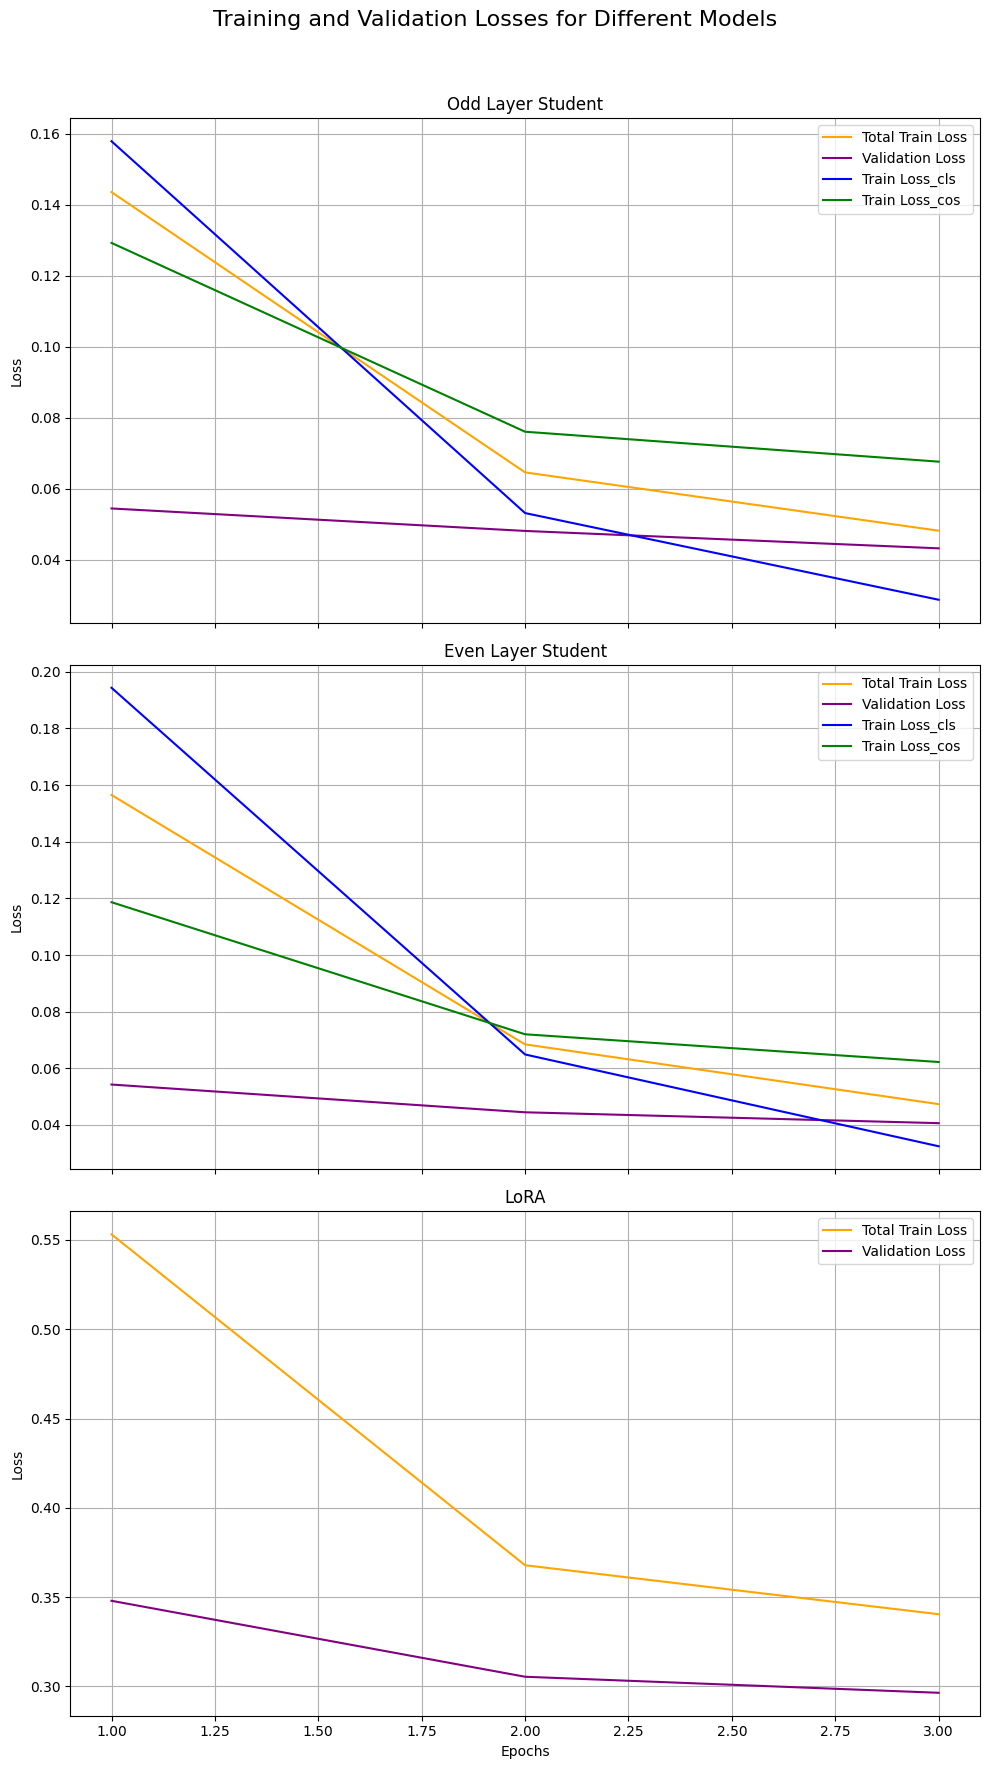

In [18]:
def plot_all_losses(
    odd_train_losses, odd_val_losses, odd_train_loss_cls, odd_train_loss_cos,
    even_train_losses, even_val_losses, even_train_loss_cls, even_train_loss_cos,
    lora_train_losses, lora_val_losses
):
    # Determine the number of epochs from one of the loss lists (assuming all are the same length)
    num_epochs = len(odd_train_losses)
    epochs = range(1, num_epochs + 1)

    # Create a figure with three subplots, stacked vertically
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

    # Subplot 1: Odd Layer Student
    axes[0].plot(epochs, odd_train_losses, label="Total Train Loss", color="orange")
    axes[0].plot(epochs, odd_val_losses, label="Validation Loss", color="purple")
    axes[0].plot(epochs, odd_train_loss_cls, label="Train Loss_cls", color="blue")
    axes[0].plot(epochs, odd_train_loss_cos, label="Train Loss_cos", color="green")
    axes[0].set_title("Odd Layer Student")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Subplot 2: Even Layer Student
    axes[1].plot(epochs, even_train_losses, label="Total Train Loss", color="orange")
    axes[1].plot(epochs, even_val_losses, label="Validation Loss", color="purple")
    axes[1].plot(epochs, even_train_loss_cls, label="Train Loss_cls", color="blue")
    axes[1].plot(epochs, even_train_loss_cos, label="Train Loss_cos", color="green")
    axes[1].set_title("Even Layer Student")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    # Subplot 3: LoRA
    axes[2].plot(epochs, lora_train_losses, label="Total Train Loss", color="orange")
    axes[2].plot(epochs, lora_val_losses, label="Validation Loss", color="purple")
    axes[2].set_title("LoRA")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("Loss")
    axes[2].legend()
    axes[2].grid(True)

    # Add a super title for the entire figure
    plt.suptitle("Training and Validation Losses for Different Models", fontsize=16)

    # Adjust layout to prevent overlap and make room for the super title
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Display the plot
    plt.show()

# Example usage
plot_all_losses(
    odd_train_losses, odd_val_losses, odd_train_loss_cls, odd_train_loss_cos,
    even_train_losses, even_val_losses, even_train_loss_cls, even_train_loss_cos,
    lora_train_losses, lora_val_losses
)

In [19]:
def evaluate_model(model, dataloader, model_name="Model", device="cuda"):
    model.eval()
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(predictions.cpu().tolist())
            all_labels.extend(batch["labels"].cpu().tolist())
    
    acc = accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"]
    macro_f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average="macro")["f1"]
    print(f"{model_name} - Test Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    return acc, macro_f1

In [20]:
# Step 1: Retrieve last training losses
last_odd_train_loss = odd_train_losses[-1]
last_even_train_loss = even_train_losses[-1]
last_lora_train_loss = lora_train_losses[-1]

odd_acc, odd_f1 = evaluate_model(student_model_odd, test_dataloader, "Odd Layer Student", device)
even_acc, even_f1 = evaluate_model(student_model_even, test_dataloader, "Even Layer Student", device)
lora_acc, lora_f1 = evaluate_model(lora_model, test_dataloader, "LoRA", device)

Odd Layer Student - Test Accuracy: 0.9100, Macro F1: 0.7471
Even Layer Student - Test Accuracy: 0.9060, Macro F1: 0.7418
LoRA - Test Accuracy: 0.8900, Macro F1: 0.5908


In [21]:
print("\nResults Table:")
print("| Model Type   | Training Loss (Last Epoch) | Test Accuracy | Macro F1 |")
print("|--------------|----------------------------|---------------|----------|")
print(f"| Odd Layer    | {last_odd_train_loss:.4f}                 | {odd_acc:.4f}        | {odd_f1:.4f}    |")
print(f"| Even Layer   | {last_even_train_loss:.4f}                 | {even_acc:.4f}        | {even_f1:.4f}    |")
print(f"| LoRA         | {last_lora_train_loss:.4f}                 | {lora_acc:.4f}        | {lora_f1:.4f}    |")


Results Table:
| Model Type   | Training Loss (Last Epoch) | Test Accuracy | Macro F1 |
|--------------|----------------------------|---------------|----------|
| Odd Layer    | 0.0482                 | 0.9100        | 0.7471    |
| Even Layer   | 0.0474                 | 0.9060        | 0.7418    |
| LoRA         | 0.3405                 | 0.8900        | 0.5908    |


| Model Type   | Training Loss (Last Epoch) | Test Accuracy | Macro F1 |
|--------------|----------------------------|---------------|----------|
| Odd Layer    | 0.0482                     | 0.9100        | 0.7471   |
| Even Layer   | 0.0474                     | 0.9060        | 0.7418   |
| LoRA         | 0.3405                     | 0.8900        | 0.5908   |

#### **Saving the odd layer student model**

In [22]:
# Save the model
torch.save(student_model_odd.state_dict(), "odd_layer_student.pth")
print("Odd Layer Student model saved to 'odd_layer_student.pth'")

Odd Layer Student model saved to 'odd_layer_student.pth'


In [23]:
tokenizer.save_pretrained("tokenizer")
print("Tokenizer saved to 'tokenizer' directory")

Tokenizer saved to 'tokenizer' directory


### **Task 4.1: Evaluation and Performance Analysis**

Below is the performance of the three models based on training loss (last epoch) and test set metrics:

| Model Type   | Training Loss (Last Epoch) | Test Accuracy | Macro F1 |
|--------------|----------------------------|---------------|----------|
| Odd Layer    | 0.0482                     | 0.9100        | 0.7471   |
| Even Layer   | 0.0474                     | 0.9060        | 0.7418   |
| LoRA         | 0.3405                     | 0.8900        | 0.5908   |

#### Analysis:
- **Training Loss**:  
  - The Odd Layer (0.0482) and Even Layer (0.0474) models have very similar training losses, indicating that both distillation methods effectively fit the training data.  
  - The LoRA model shows a much higher training loss (0.3405), suggesting it struggled to learn the training data as well as the distilled models.

- **Test Accuracy**:  
  - The Odd Layer model achieves the highest test accuracy (0.9100), followed closely by the Even Layer model (0.9060), while LoRA has the lowest (0.8900).  
  - This shows that the distilled models generalize better to the test set, with the Odd Layer model slightly outperforming the Even Layer model.

- **Macro F1 Score**:  
  - The Odd Layer model leads with a Macro F1 score of 0.7471, followed by the Even Layer model at 0.7418, while LoRA trails at 0.5908.  
  - Higher Macro F1 scores for the distilled models suggest they handle imbalanced classes more effectively than LoRA.

#### Differences in Performance:
- **Distillation vs. LoRA**:  
  - The distilled models (Odd and Even Layer) outperform LoRA in accuracy and Macro F1, likely due to their simpler architectures and targeted knowledge transfer from specific layers.  
  - LoRA’s lower performance may result from its parameter-efficient adaptation not capturing the dataset’s complexity as well as distillation.

- **Odd vs. Even Layers**:  
  - The Odd Layer model slightly edges out the Even Layer model in test accuracy and Macro F1. This could be due to the specific layers distilled (odd vs. even), with odd layers possibly capturing more relevant features.

---

### **Task 4.2: Challenges and Proposed Improvements**

#### Challenges Encountered:
- **Class Imbalance**:  
  - The dataset likely has imbalanced classes, as seen in LoRA’s low Macro F1 score (0.5908) compared to the distilled models (0.7471 and 0.7418). This suggests LoRA struggles with minority classes.  
- **Model Complexity**:  
  - LoRA adapts a full 12-layer model, which may overfit the majority class, while the distilled models’ 6-layer designs generalize better.  
- **Hyperparameter Tuning**:  
  - LoRA’s performance is sensitive to settings like rank and learning rate, and its current configuration may not be optimal, unlike the distilled models, which require less tuning.

#### Proposed Improvements:
- **Class Weights**:  
  - Add class weights to LoRA’s loss function to prioritize minority classes, potentially boosting its Macro F1 score.  
- **Data Augmentation**:  
  - Use oversampling or synthetic data generation for minority classes to balance the dataset, benefiting all models, especially LoRA.  
- **Hyperparameter Tuning**:  
  - Adjust LoRA’s rank (e.g., `r=8` or `r=16`) and learning rate to optimize its performance and close the gap with the distilled models.

---

### **Summary**
The distilled models (Odd Layer and Even Layer) outperform LoRA across all metrics, likely due to their simpler, targeted architectures and better handling of class imbalance. LoRA’s higher training loss and weaker generalization could be improved with class weights, data augmentation, and hyperparameter tuning.